In [1]:
# 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/aicontest/anaconda3/envs/seg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/ssd/data/aicontest/anaconda3/envs/seg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 데이터 셋 준비
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9912422/9912422 [00:01<00:00, 5373834.26it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28881/28881 [00:00<00:00, 158001.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1648877/1648877 [00:01<00:00, 1467026.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4542/4542 [00:00<00:00, 7586829.46it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# CNN 모델
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# 모델 초기화, 손실 함수 및 옵티마이저 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 모델 학습
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=20)

Epoch [1/20], Loss: 0.0632
Epoch [2/20], Loss: 0.0119
Epoch [3/20], Loss: 0.0489
Epoch [4/20], Loss: 0.0326
Epoch [5/20], Loss: 0.0002
Epoch [6/20], Loss: 0.0000
Epoch [7/20], Loss: 0.0001
Epoch [8/20], Loss: 0.0301
Epoch [9/20], Loss: 0.0167
Epoch [10/20], Loss: 0.0249
Epoch [11/20], Loss: 0.0001
Epoch [12/20], Loss: 0.0209
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0001
Epoch [15/20], Loss: 0.0003
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0001


In [11]:
# FGSM 공격 함수 정의
def fgsm_attack(image, epsilon, data_grad):
    # FGSM: 입력 데이터를 손실 그래디언트 방향으로 변경
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # [0, 1]로 값 제한
    return perturbed_image

In [24]:
model_fgsm = SimpleCNN().to(device)
optimizer_fgsm = optim.Adam(model_fgsm.parameters(), lr=0.001)

# FGSM 학습 함수
def fgsm_train_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True  # 그래디언트 계산을 위해 설정

            # 원본 이미지로 예측
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 역전파를 통해 그래디언트 계산
            optimizer.zero_grad()
            loss.backward(retain_graph=True)  # 여기서 images.grad가 계산됨

            # FGSM 적대적 샘플 생성
            fgsm_image = fgsm_attack(images, epsilon=0.3, data_grad=images.grad)
            
            # FGSM 샘플로 예측
            outputs_fgsm = model(fgsm_image)
            loss_fgsm = criterion(outputs_fgsm, labels)

            # 원본 손실과 FGSM 손실 결합
            total_loss = 0.5 * loss + 0.5 * loss_fgsm

            # 최종 손실로 역전파 및 최적화
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}")

fgsm_train_model(model_fgsm, train_loader, criterion, optimizer_fgsm, epochs=20)

Epoch [1/20], Loss: 0.1129
Epoch [2/20], Loss: 0.1012
Epoch [3/20], Loss: 0.0068
Epoch [4/20], Loss: 0.0117
Epoch [5/20], Loss: 0.0119
Epoch [6/20], Loss: 0.0132
Epoch [7/20], Loss: 0.0022
Epoch [8/20], Loss: 0.1075
Epoch [9/20], Loss: 0.0061
Epoch [10/20], Loss: 0.0018
Epoch [11/20], Loss: 0.0978
Epoch [12/20], Loss: 0.1429
Epoch [13/20], Loss: 0.0018
Epoch [14/20], Loss: 0.0015
Epoch [15/20], Loss: 0.0006
Epoch [16/20], Loss: 0.0088
Epoch [17/20], Loss: 0.0006
Epoch [18/20], Loss: 0.0685
Epoch [19/20], Loss: 0.1466
Epoch [20/20], Loss: 0.0007


In [25]:
def test_with_fgsm(model, test_loader, epsilon):
    correct = 0
    adv_examples = []

    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # 원본 데이터로 예측
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # 가장 높은 확률의 클래스

        if init_pred.item() != target.item():
            continue

        # 손실 계산 후 그래디언트 계산
        loss = criterion(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # FGSM으로 적대적 샘플 생성
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 적대적 샘플로 예측
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
        else:
            # 적대적 샘플 저장
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {final_acc:.4f}")
    return final_acc, adv_examples

In [26]:
# 다양한 epsilon 값으로 실험
epsilons = [0, 0.05, 0.1, 0.2, 0.3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test_with_fgsm(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

print("== fgsm robustness training ==")
accuracies_fgsm = []
examples_fgsm = []
for eps in epsilons:
    acc, ex = test_with_fgsm(model_fgsm, test_loader, eps)
    accuracies_fgsm.append(acc)
    examples_fgsm.append(ex)

Epsilon: 0	Test Accuracy = 0.9907
Epsilon: 0.05	Test Accuracy = 0.9492
Epsilon: 0.1	Test Accuracy = 0.8491
Epsilon: 0.2	Test Accuracy = 0.5615
Epsilon: 0.3	Test Accuracy = 0.2834
== fgsm robustness training ==
Epsilon: 0	Test Accuracy = 0.9898
Epsilon: 0.05	Test Accuracy = 0.9728
Epsilon: 0.1	Test Accuracy = 0.9656
Epsilon: 0.2	Test Accuracy = 0.9775
Epsilon: 0.3	Test Accuracy = 0.9802


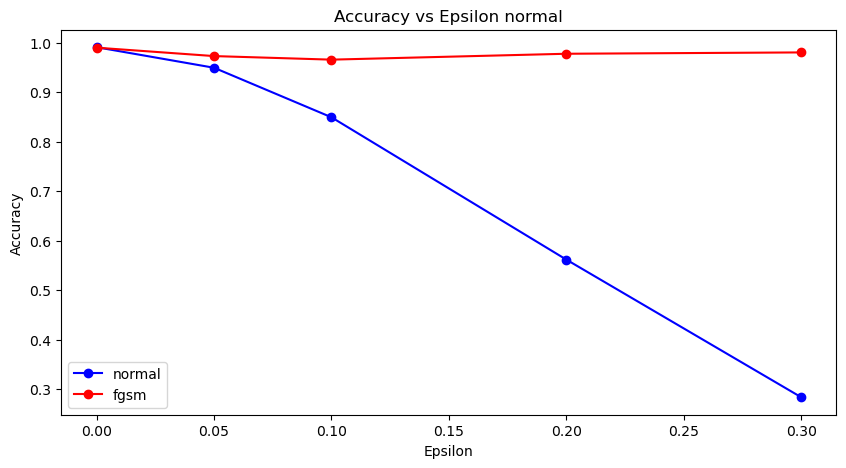

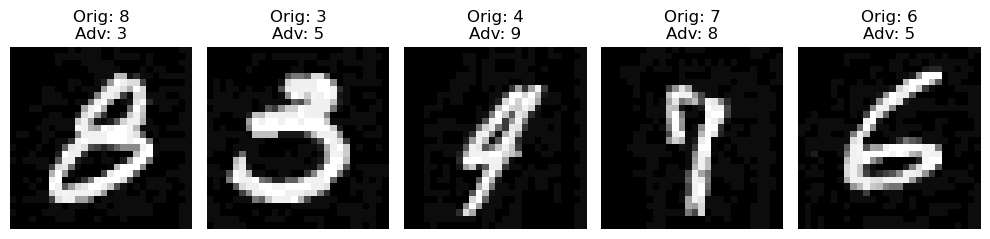

In [27]:
# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, marker="o", color='b', label='normal')
plt.plot(epsilons, accuracies_fgsm, marker="o", color='r', label='fgsm')
plt.title("Accuracy vs Epsilon normal")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 적대적 샘플 시각화
plt.figure(figsize=(10, 5))
for i, (orig, adv, ex) in enumerate(examples[1]):
    plt.subplot(1, 5, i+1)
    plt.title(f"Orig: {orig}\nAdv: {adv}")
    plt.imshow(ex, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()